## Tacotron 2 inference code 
Edit the variables **checkpoint_path** and **text** to match yours and run the entire code to generate plots of mel outputs, alignments and audio synthesis from the generated mel-spectrogram using Griffin-Lim.

#### Import libraries and setup matplotlib

In [2]:
def plot_data(data, figsize=(16, 4)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='bottom', 
                       interpolation='none')

#### Setup hparams

In [3]:
hparams = create_hparams()
hparams.sampling_rate = 22050

#### Load model from checkpoint

In [4]:
checkpoint_path = "tacotron2_statedict.pt"
model = load_model(hparams)
model.load_state_dict(torch.load(checkpoint_path)['state_dict'])
_ = model.cuda().eval().half()

#### Load WaveGlow for mel2audio synthesis and denoiser

In [22]:
waveglow_path = '/media/DATAHDD01/Tranformer TTS/waveglow_256channels_universal_v5.pt'
waveglow = torch.load(waveglow_path)['model']
waveglow.cuda().eval().half()
for k in waveglow.convinv:
    k.float()
denoiser = Denoiser(waveglow)

/home/airobotics/.local/lib/python3.7/site-packages/torch/serialization.py:868: SourceChangeWarning: source code of class 'torch.nn.modules.conv.ConvTranspose1d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/airobotics/.local/lib/python3.7/site-packages/torch/serialization.py:868: SourceChangeWarning: source code of class 'torch.nn.modules.container.ModuleList' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/airobotics/.local/lib/python3.7/site-packages/torch/serialization.py:868: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv1d' has changed. you can retrieve the original source code by acc

#### Prepare text input

In [6]:
text = "Waveglow is really awesome!"
sequence = np.array(text_to_sequence(text, ['english_cleaners']))[None, :]
sequence = torch.autograd.Variable(
    torch.from_numpy(sequence)).cuda().long()

#### Decode text input and plot results

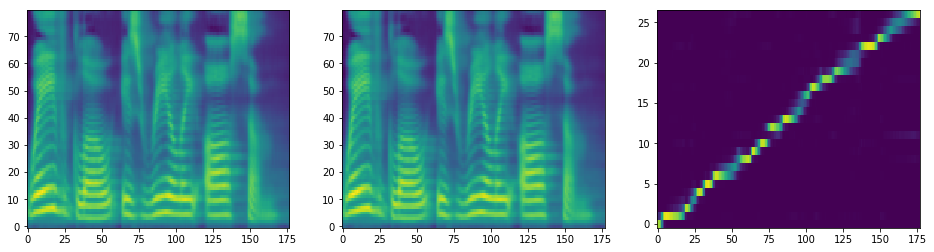

In [7]:
mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence)
plot_data((mel_outputs.float().data.cpu().numpy()[0],
           mel_outputs_postnet.float().data.cpu().numpy()[0],
           alignments.float().data.cpu().numpy()[0].T))

#### Synthesize audio from spectrogram using WaveGlow

In [4]:
from specgen import *

In [46]:
mel_out,sr = mel_spectogram_generator('audio_files/speech.wav')
mel_out = mel_out.unsqueeze(0)

NameError: name 'mel_spectogram_generator' is not defined

In [20]:
with torch.no_grad():
    audio = waveglow.infer(mel_out.cuda().half(), sigma=0.666)
ipd.Audio(audio[0].data.cpu().numpy(), rate=16000)

#### (Optional) Remove WaveGlow bias

In [9]:
audio_denoised = denoiser(audio, strength=0.01)[:, 0]
ipd.Audio(audio_denoised.cpu().numpy(), rate=hparams.sampling_rate) 

In [11]:
import torch
import numpy as np
import torch.nn.functional as F
from torch.autograd import Variable
from scipy.signal import get_window
from librosa.util import pad_center, tiny
from scipy.io.wavfile import read
import librosa
import librosa.util as librosa_util
from librosa.filters import mel as librosa_mel_fn
from scipy.signal import resample
from IPython.display import Audio
import torchaudio

import matplotlib
%matplotlib inline
import matplotlib.pylab as plt

import IPython.display as ipd

import sys
sys.path.append('waveglow/')
sys.path.append('tacotron2')
import numpy as np
import torch

from denoiser import Denoiser


def dynamic_range_compression(x, C=1, clip_val=1e-5):
    """
    PARAMS
    ------
    C: compression factor
    """
    return torch.log(torch.clamp(x, min=clip_val) * C)

def dynamic_range_decompression(x, C=1):
    """
    PARAMS
    ------
    C: compression factor used to compress
    """
    return torch.exp(x) / C


def window_sumsquare(window, n_frames, hop_length=200, win_length=800,
                     n_fft=800, dtype=np.float32, norm=None):
    """
    # from librosa 0.6
    Compute the sum-square envelope of a window function at a given hop length.

    This is used to estimate modulation effects induced by windowing
    observations in short-time fourier transforms.

    Parameters
    ----------
    window : string, tuple, number, callable, or list-like
        Window specification, as in `get_window`

    n_frames : int > 0
        The number of analysis frames

    hop_length : int > 0
        The number of samples to advance between frames

    win_length : [optional]
        The length of the window function.  By default, this matches `n_fft`.

    n_fft : int > 0
        The length of each analysis frame.

    dtype : np.dtype
        The data type of the output

    Returns
    -------
    wss : np.ndarray, shape=`(n_fft + hop_length * (n_frames - 1))`
        The sum-squared envelope of the window function
    """
    if win_length is None:
        win_length = n_fft

    n = n_fft + hop_length * (n_frames - 1)
    x = np.zeros(n, dtype=dtype)

    # Compute the squared window at the desired length
    win_sq = get_window(window, win_length, fftbins=True)
    win_sq = librosa_util.normalize(win_sq, norm=norm)**2
    win_sq = librosa_util.pad_center(win_sq, n_fft)

    # Fill the envelope
    for i in range(n_frames):
        sample = i * hop_length
        x[sample:min(n, sample + n_fft)] += win_sq[:max(0, min(n_fft, n - sample))]
    return x

class STFT(torch.nn.Module):
    """adapted from Prem Seetharaman's https://github.com/pseeth/pytorch-stft"""
    def __init__(self, filter_length=800, hop_length=200, win_length=800,
                 window='hann'):
        super(STFT, self).__init__()
        self.filter_length = filter_length
        self.hop_length = hop_length
        self.win_length = win_length
        self.window = window
        self.forward_transform = None
        scale = self.filter_length / self.hop_length
        fourier_basis = np.fft.fft(np.eye(self.filter_length))

        cutoff = int((self.filter_length / 2 + 1))
        fourier_basis = np.vstack([np.real(fourier_basis[:cutoff, :]),
                                   np.imag(fourier_basis[:cutoff, :])])

        forward_basis = torch.FloatTensor(fourier_basis[:, None, :])
        inverse_basis = torch.FloatTensor(
            np.linalg.pinv(scale * fourier_basis).T[:, None, :])

        if window is not None:
            assert(win_length >= filter_length)
            # get window and zero center pad it to filter_length
            fft_window = get_window(window, win_length, fftbins=True)
            fft_window = pad_center(fft_window, filter_length)
            fft_window = torch.from_numpy(fft_window).float()

            # window the bases
            forward_basis *= fft_window
            inverse_basis *= fft_window

        self.register_buffer('forward_basis', forward_basis.float())
        self.register_buffer('inverse_basis', inverse_basis.float())

    def transform(self, input_data):
        num_batches = input_data.size(0)
        num_samples = input_data.size(1)

        self.num_samples = num_samples

        # similar to librosa, reflect-pad the input
        input_data = input_data.view(num_batches, 1, num_samples)
        input_data = F.pad(
            input_data.unsqueeze(1),
            (int(self.filter_length / 2), int(self.filter_length / 2), 0, 0),
            mode='reflect')
        input_data = input_data.squeeze(1)

        forward_transform = F.conv1d(
            input_data,
            Variable(self.forward_basis, requires_grad=False),
            stride=self.hop_length,
            padding=0)

        cutoff = int((self.filter_length / 2) + 1)
        real_part = forward_transform[:, :cutoff, :]
        imag_part = forward_transform[:, cutoff:, :]

        magnitude = torch.sqrt(real_part**2 + imag_part**2)
        phase = torch.autograd.Variable(
            torch.atan2(imag_part.data, real_part.data))

        return magnitude, phase

    def inverse(self, magnitude, phase):
        recombine_magnitude_phase = torch.cat(
            [magnitude*torch.cos(phase), magnitude*torch.sin(phase)], dim=1)

        inverse_transform = F.conv_transpose1d(
            recombine_magnitude_phase,
            Variable(self.inverse_basis, requires_grad=False),
            stride=self.hop_length,
            padding=0)

        if self.window is not None:
            window_sum = window_sumsquare(
                self.window, magnitude.size(-1), hop_length=self.hop_length,
                win_length=self.win_length, n_fft=self.filter_length,
                dtype=np.float32)
            # remove modulation effects
            approx_nonzero_indices = torch.from_numpy(
                np.where(window_sum > tiny(window_sum))[0])
            window_sum = torch.autograd.Variable(
                torch.from_numpy(window_sum), requires_grad=False)
            inverse_transform[:, :, approx_nonzero_indices] /= window_sum[approx_nonzero_indices]

            # scale by hop ratio
            inverse_transform *= float(self.filter_length) / self.hop_length

        inverse_transform = inverse_transform[:, :, int(self.filter_length/2):]
        inverse_transform = inverse_transform[:, :, :-int(self.filter_length/2):]

        return inverse_transform

    def forward(self, input_data):
        self.magnitude, self.phase = self.transform(input_data)
        reconstruction = self.inverse(self.magnitude, self.phase)
        return reconstruction
        
class TacotronSTFT(torch.nn.Module):
    def __init__(self, filter_length=1024, hop_length=256, win_length=1024,
                 n_mel_channels=80, sampling_rate=22050, mel_fmin=0.0,
                 mel_fmax=None):
        super(TacotronSTFT, self).__init__()
        self.n_mel_channels = n_mel_channels
        self.sampling_rate = sampling_rate
        self.stft_fn = STFT(filter_length, hop_length, win_length)
        
        mel_basis = librosa_mel_fn(
            sampling_rate, filter_length, n_mel_channels, mel_fmin, mel_fmax)
        mel_basis = torch.from_numpy(mel_basis).float()
        self.register_buffer('mel_basis', mel_basis)

    def spectral_normalize(self, magnitudes):
        output = dynamic_range_compression(magnitudes)
        return output

    def spectral_de_normalize(self, magnitudes):
        output = dynamic_range_decompression(magnitudes)
        return output

    def mel_spectrogram(self, y):
        """Computes mel-spectrograms from a batch of waves
        PARAMS
        ------
        y: Variable(torch.FloatTensor) with shape (B, T) in range [-1, 1]

        RETURNS
        -------
        mel_output: torch.FloatTensor of shape (B, n_mel_channels, T)
        """
        assert(torch.min(y.data) >= -1)
        assert(torch.max(y.data) <= 1)

        magnitudes, phases = self.stft_fn.transform(y)
        magnitudes = magnitudes.data
        mel_output = torch.matmul(self.mel_basis, magnitudes)
        mel_output = self.spectral_normalize(mel_output)
        return mel_output



def resample_audio(data, orig_sr, target_sample_rate):
    # Read the audio file

    # Calculate the resampling ratio
    resampling_ratio = target_sample_rate / orig_sr
    
    # Perform resampling
    resampled_data = resample(data, int(len(data) * resampling_ratio))
    
    # Convert the sample rate to the target sample rate
    resampled_sample_rate = int(orig_sr * resampling_ratio)
    
    return resampled_data, resampled_sample_rate


def load_wav_to_torch(full_path, sr):
    sampling_rate, data = read(full_path)
    
    if sampling_rate != sr:
        data, _ = resample_audio(data,sampling_rate,sr)

    return torch.FloatTensor(data.astype(np.float32))


def get_mel(stft,filename,sampling_rate,max_wav_value=32768.0,load_mel_from_disk=False):
        if not load_mel_from_disk:
            audio = load_wav_to_torch(filename, sampling_rate)
            audio_norm = audio / max_wav_value
            audio_norm = audio_norm.unsqueeze(0)
            audio_norm = torch.autograd.Variable(audio_norm, requires_grad=False)
            melspec = stft.mel_spectrogram(audio_norm)
            melspec = torch.squeeze(melspec, 0)
        else:
            melspec = torch.from_numpy(np.load(filename))
            assert melspec.size(0) == stft.n_mel_channels, (
                'Mel dimension mismatch: given {}, expected {}'.format(
                    melspec.size(0), stft.n_mel_channels))

        return melspec


In [6]:
stft = TacotronSTFT(filter_length=1024,hop_length=256,win_length=1024)

/home/airobotics/.local/lib/python3.7/site-packages/ipykernel_launcher.py:110: FutureWarning: Pass size=1024 as keyword args. From version 0.10 passing these as positional arguments will result in an error
/home/airobotics/.local/lib/python3.7/site-packages/ipykernel_launcher.py:195: FutureWarning: Pass sr=22050, n_fft=1024, n_mels=80, fmin=0.0, fmax=None as keyword args. From version 0.10 passing these as positional arguments will result in an error


In [7]:
mel = get_mel(stft,"audio_files/speech.wav",sampling_rate=22050)

In [22]:
waveglow_path = '/media/DATAHDD01/Tranformer TTS_PlayGround/waveglow_256channels_universal_v5.pt'
waveglow = torch.load(waveglow_path)['model']
waveglow.cuda().eval()
for k in waveglow.convinv:
    k.float()
denoiser = Denoiser(waveglow)

/home/airobotics/.local/lib/python3.7/site-packages/torch/serialization.py:868: SourceChangeWarning: source code of class 'torch.nn.modules.conv.ConvTranspose1d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/airobotics/.local/lib/python3.7/site-packages/torch/serialization.py:868: SourceChangeWarning: source code of class 'torch.nn.modules.container.ModuleList' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/airobotics/.local/lib/python3.7/site-packages/torch/serialization.py:868: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv1d' has changed. you can retrieve the original source code by acc

In [25]:
with torch.no_grad():
    audio = waveglow.infer(mel.cuda(), sigma=0.666)
ipd.Audio(audio[0].data.cpu().numpy(), rate=22050)

IndexError: too many indices for tensor of dimension 2

In [55]:
import librosa
def mel_spectrogram_generator(audio_file, plot=None):
    waveform, sample_rate = librosa.load(audio_file,sr=22050)
    waveform = torch.FloatTensor(waveform).unsqueeze(0)
    transform = torchaudio.transforms.MelSpectrogram(sample_rate, n_mels=80,n_fft=1024,hop_length=256,win_length=1024)
    mel_specgram = transform(waveform)

    if plot:
        plot_spectrogram(mel_specgram[0], title="torchaudio")

    return mel_specgram, sample_rate

In [72]:
mel_out, sr = mel_spectrogram_generator('audio_files/speech.wav')

In [39]:
with torch.no_grad():
    audio = waveglow.infer(mel.unsqueeze(0).cuda(), sigma=0.666)
ipd.Audio(audio[0].data.cpu().numpy(), rate=22050)

RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.cuda.HalfTensor) should be the same

In [38]:
audio

tensor([[nan, nan, nan,  ..., nan, nan, nan]], device='cuda:0',
       dtype=torch.float16)

In [10]:
from tts_transformers import *
from model_utils import *

class TTS_Model(nn.Module):
    
    def __init__(self,configs,device):
        super(TTS_Model,self).__init__()
        
        self.configs = configs
        self.device = device

        self.input_embed = nn.Embedding(configs['EncDec_Configs']['vocab_size'],configs['EncDec_Configs']['embed_dim'])
        self.wpe = PositionalEncoding(configs['EncDec_Configs']['embed_dim'],configs['EncDec_Configs']['dropout'])
        
        enc_layer = TransformerEncoderLayer(configs['EncDec_Configs']['embed_dim'],configs['EncDec_Configs']['n_head'],
                                            configs['EncDec_Configs']['d_ff'],configs['EncDec_Configs']['dropout'],batch_first=True)
        
        dec_layer = TransformerDecoderLayer(configs['EncDec_Configs']['embed_dim'],configs['EncDec_Configs']['n_head'],
                                            configs['EncDec_Configs']['d_ff'],configs['EncDec_Configs']['dropout'],batch_first=True)
        
        self.encode = TransformerEncoder(enc_layer,num_layers=configs['EncDec_Configs']['n_encoder_layer'])
        self.decode = TransformerDecoder(dec_layer,configs['EncDec_Configs']['n_decoder_layer'])
        
        self.encoder_prenet = EncoderPrenet(configs['EncDec_Configs']['embed_dim'])
        self.decoder_prenet = DecoderPrenet(configs['Audio_Configs']['num_mels'],configs['EncDec_Configs']['embed_dim'])
        
        self.head = HeadPredictor(configs,configs['EncDec_Configs']['dropout'])
        
        
    def forward(self,src,mel):
        """pass input tokens and mel spectrograms

        Args:
            src (_type_): text input of shape (B, T)
            mel (_type_): mel spectrogram of shape (B, T, n_mel)
            mel_mask (_type_): _description_
            src_key_padding_mask (_type_): _description_
            
        """
        
        memory = self.encoder(src)
        
        mel_before, mel_final, gate = self.decoder(mel,memory)
        
        return mel_before, mel_final, gate
    
    def encoder(self,src):
        """ pass input token to produce memory

        Args:
            src (_type_): mel spectrogram (B, T)
            
        """
        
        _, src_t = src.shape

        src_padding = self.make_src_pad_mask(src,self.configs['EncDec_Configs']['pad_idx'])
        src_tok_emb = self.input_embed(src)
        
        src_tok_emb = self.encoder_prenet(src_tok_emb)
        src_tok_emb = self.wpe(src_tok_emb)

        memory = self.encode(src_tok_emb,src_key_padding_mask=src_padding)

        return memory
    
    def decoder(self,mel, memory):
        """ 
        the decoder receives mel spectrograms (B, T, n_mel) an memory of the encoder layers,
        the docoder then passes it to decoder layer and head layer to predict the spectrograms,
        and the gate output.

        Args:
            mel (_type_): mel spectrogram (B, T, n_mel)
            mel_mask (_type_): 
            memory  (_type_): memory of encoder (B, T, n_hid)
            
        """
        _, tgt_t, dim = mel.shape
        self.register_buffer('attn_mask',torch.triu(torch.full((tgt_t,tgt_t), float('-inf')).to(self.device),diagonal=1))
        
        mel_in = self.decoder_prenet(mel)
        mel_in = self.wpe(mel_in)
        
        output = self.decode(mel_in, memory, tgt_mask = self.attn_mask)
        
        mel_before, mel_final, gate = self.head(output)
        
        return mel_before, mel_final, gate
        
        
    
    def make_src_pad_mask(self,src,pad_idx):
        src_padding = (src == pad_idx).float()
        return src_padding
        
        


In [ ]:
from utils import load_configs
configs = load_configs('hparams.yaml')

model = TTS_Model(configs,device='cpu')

src = torch.tensor([[2,3,2,4,5,6,0,0,0],[3,12,3,5,19,3,7,8,0]])
mel = torch.randn(2, 18, 80)


In [ ]:
mel_before, mel_final, gate = model(src,mel)
from losses import TTS_Loss

In [13]:
from utils import load_configs
configs = load_configs('hparams.yaml')

In [14]:
model = TTS_Model(configs,device='cpu')

In [18]:
src = torch.tensor([[2,3,2,4,5,6,0,0,0],[3,12,32,5,64,3,7,8,0]])
mel = torch.randn(2, 18, 80)

In [17]:
src.shape

torch.Size([2, 9])

In [6]:
x = torch.randn(8, 13, 768)

In [8]:
mel_before, mel_after, gate =  head(x)

x_mel_linear shape:  torch.Size([8, 13, 80])
